In [1]:
import style
style._set_css_style("custom.css")

In [2]:
import numpy as np
from tabulate import tabulate as tab
from thermo.chemical import Chemical as chem
from thermo.chemical import Mixture as mix

### Exchanger Design:

#### This code was created to design a shell and tube heat exchanger.

#### Reference:
“Chemical Engineering Design” Vol. 6 Third Edition: by Coulson, Richardson,and Sinnott: Butterworh-Heinemann, 2003. [7]

#### Problem.1
Design an exchanger to subcool condensate from a benzene condenser from 95 oC to
40 oC. Flow rate of methanol 100,000 kg/h. Brackish water will be used as the coolant,
with a temperature rise from 25 to 40 oC.

In [36]:
# Input Data
#################################################################################### 
print("Equipment Information:")
Equipment_Type = input("\nPlease enter the equipment Type: ")
Equipment_Function = input("Please enter the equipment Function: ")
Equipment_ID = input("Please enter the equipment ID: ")
#cold stream enters the shell side.
print("Shell side stream:")
shell_mass =float(input("\nPlease enter the mass flowrate in the shell side in kg/h:" ))
compounds_No_s = int(input("Please enter the compounds number of the feed: "))
compounds_s,fractions_s = [],[]
counter = 0
for i in range(0,compounds_No_s):
    counter+=1
    compound = input(f"Please enter the name of compund { counter}: ")
    fraction = float(input(f"Please enter the mass fraction of the {compound}: "))
    compounds_s.append(compound)
    fractions_s.append(fraction)
shell_Ti =float(input("Please enter the inlet temperture in the shell side in oC:" ))
shell_To = float(input("Please enter the outlet temperature in the shell side in oC:" ))
shell_f = float(input("Please enter the fluid fouling factor in the shell side from Table.12.2:" ))
shell_f = 1 / shell_f
shell_material = input("Please enter the shell material: ")

#hot stream enters the tube side.
print("Tube side stream:")
tube_mass = float(input("\nPlease enter the mass flowrate in the tube side in kg/h:" ))
compounds_No_t = int(input("Please enter the compounds number of the feed: "))
compounds_t,fractions_t = [],[]
counter = 0
for i in range(0,compounds_No_t):
    counter+=1
    compound = input(f"Please enter the name of compund { counter}: ")
    fraction = float(input(f"Please enter the mass fraction of the {compound}: "))
    compounds_t.append(compound)
    fractions_t.append(fraction)
tube_Ti = float(input("Please enter the inlet temperture in the tube side in oC:" ))
tube_To = float(input("Please enter the outlet temperature in the tube side in oC:" ))
tube_f = float(input("Please enter the fluid fouling factor in the tube side from Table.12.2:" ))
tube_f = 1 / tube_f
tube_material = input("Please enter the tubes material: ")
tube_K = chem(tube_material)
tube_k = tube_K.k

print("\n Other requirements:")

U = float(input("Please estimate the overall heat transfer cofficient From Table.12.1: " ))
OD = float(input("Please enter the tube diameter from Table.12.3 in m: " ))  
Thickness = float(input("Please estimate the tube thickness in m: " ))  
L = float(input("Please estimate the tube length in m: " ))

# Physical properties preparation
##################################################################################
mixture_s = mix(compounds_s,ws=fractions_s,T=shell_Ti+273)
shell_Cp =mixture_s.Cp             #heat capasity Cp in the shell side in kJ/kg oC
shell_p = mixture_s.rho            #fluid density in the shell side in kg/m^3
shell_V = mixture_s.ViscosityLiquidMixture(T=shell_Ti+273,P = 1*10**5,ws=fractions_s) #fluid viscosty in the shell side in kg/m s
shell_kf = mixture_s.k               #fluid thermal conductivity in the shell side in W/m oC
mixture_t = mix(compounds_t,ws=fractions_t,T=tube_Ti+273)
tube_Cp = mixture_t.Cp                   #heat capasity Cp in the tube side in kJ/kg oC
tube_p = mixture_t.rho                   #fluid density in the tube side in kg/m^3
tube_V = mixture_t.ViscosityLiquidMixture(T=tube_Ti+273,P = 1*10**5,ws=fractions_t) #fluid viscosty in the tube side in kg/m s
tube_kf = mixture_t.k         #fluid thermal conductivity in the tube side in W/m oC

# Design Calculations
#################################################################################### 

ID = OD - 2 * Thickness
A_tube = np.pi * OD * L
LMTD = ((tube_Ti-shell_To)-(tube_To-shell_Ti))/(np.log((tube_Ti-shell_To)/(tube_To-shell_Ti)))
R = (tube_Ti-tube_To)/(shell_To-shell_Ti)
S = (shell_To-shell_Ti)/(tube_Ti-shell_Ti)
# For a 1 shell: 2 tube pass exchanger, the correction factor is given by the following equation.
Ft = (np.sqrt(R**2+1)*np.log((1-S)/(1-R*S)))/((R-1)*(np.log((2-S*(R+1-np.sqrt(R**2+1)))/(2-S*(R+1+np.sqrt(R**2+1))))))
Delta_T_m = Ft * LMTD
Duty = shell_mass/3600 * shell_Cp/1000 *(shell_To - shell_Ti) # No phase change
A_total = Duty*1000 / (U * Delta_T_m)
tube_No = int(A_total/A_tube + 1)
pass_No = 2 
K_1 = 0.249 
n_1 = 2.207 
D_b = OD * (tube_No/K_1)**(1/n_1)
P_t = 1.25 * OD
# The below correlations are obtained from figure 12.10.
if Equipment_Type == "Floating Head":
    BDC = 0.00909091 * D_b + 0.086
elif "Fixed Tube" or "U-Tube":
    BDC = 0.01 * D_b + 0.008
D_s = D_b + BDC
B_s = 0.4 * D_s
A_s = ((P_t-OD)*D_s*B_s)/P_t
u_s = shell_mass/3600 /(shell_p*A_s)
d_e = 1.27/OD *(P_t**2-0.785*OD**2)
Re_s = (u_s*shell_p*d_e)/shell_V
Pr_s = (shell_V*shell_Cp*1000)/shell_kf
jh_s = float(input(f"The Reynolds number in the shell side = {Re_s}  Please enter the jh factor from Figure.12.23: "))
jf_s = float(input(f"The Reynolds number in the shell side = {Re_s}  Please enter the jf factor from Figure.12.24: "))
hs = (jh_s*Re_s*Pr_s**(1/3)*shell_kf)/d_e * (shell_V/0.001)**0.14
Ps_drop = (8*jf_s * (D_s/d_e)*(L/B_s)*((shell_p*u_s**2)/2)* (shell_V/0.001)**(-0.14))/1000
A_cross_t = tube_No*(np.pi*ID**2/4)
u_t = tube_mass/3600/(tube_p*A_cross_t)
Re_t = (u_t*tube_p*ID)/tube_V
Pr_t = (tube_V*tube_Cp*1000)/tube_kf
jh_t = float(input(f"The Reynolds number in the tube side = {Re_t}  Please enter the jh factor from Figure.12.29: "))
jf_t = float(input(f"The Reynolds number in the tube side = {Re_t}  Please enter the jf factor from Figure.12.30: "))
ht = (jh_t*Re_t*Pr_t**(1/3)*tube_kf)/ID       # the vicostity correction term is neglegable (tube_V/W_V)**0.14
Pt_drop =pass_No* (8*jf_t * (L/ID)+2.5)*((tube_p*u_t**2)/2)#      (tube_V/W_V)**(-0.14)
Uo = 1/(1/hs + 1/shell_f + (OD*np.log(OD/ID))/(2*tube_k) + OD/ID*1/tube_f + OD/ID*1/ht)

# Design Table Code
###################################################################################


Ex_sheet = [("Equipment Name","Shell & Tube \nHeat Exchanger","Equipment ID","Heat Transfer \nArea (m^2)","Function"),
           ("  Type",Equipment_Type,Equipment_ID,"{:.4f}".format(A_total),Equipment_Function),
           ("Material of Conctruction","Shell ",shell_material,"Tubes",tube_material),
           ("","Shell","","Tube"),("DATA PER UNIT","IN","OUT","IN","OUT"),
           ("Mass Flow (kg/h)",shell_mass,shell_mass,tube_mass,tube_mass),
           ("Temperature  (oC)",shell_Ti,shell_To,tube_Ti,tube_To),
           ("Density (kg/m^3)","{:.4f}".format(shell_p),"NA","{:.4f}".format(tube_p),"NA"),
           ("Viscosity (kg/m s)","{:.6f}".format(shell_V),"NA","{:.6f}".format(tube_V),"NA"),
           ("Thermal Conductivity (W/m oC)","{:.4f}".format(shell_kf),"----","{:.4f}".format(tube_kf),"----"),
           ("Pressure Drop (kPa)","{:.4f}".format(Ps_drop),"----","{:.4f}".format(Pt_drop),"----"),
           ("Fluid Velocity (m/s)","{:.4f}".format(u_s),"----","{:.4f}".format(u_t),"----"),
           ("Heat Transfer Coefficient \n(W/m^2 oC)","Shell","{:.4f}".format(hs),"Tube","{:.4f}".format(ht)),
           ("Tube No.",tube_No,"----","Passes No.",pass_No),("Tube OD \ ID (mm)",OD*1000,"{:.4f}".format(ID*1000),"Tube Length (m)",L),
           ("Baffles Spacing (m)","{:.4f}".format(B_s),"----","Shell D (m)","{:.4f}".format(D_s)),
           ("LMTD oC","{:.4f}".format(LMTD),"----","Ft factor","{:.4f}".format(Ft)),
           ("Overall Heat Transfer\nCoefficient (W/m^2 oC)","{:.4f}".format(Uo),"----","Heat Duty (kW)","{:.4f}".format(Duty))
            
           ]
print("\nThe Specifications Sheet\n:")          
print(tab(Ex_sheet,tablefmt="fancy_grid"))
Ex_sheet.clear()



Equipment Information:

Please enter the equipment Type: Fixed Tube
Please enter the equipment Function: Benzene Condensation
Please enter the equipment ID: E - 101
Shell side stream:

Please enter the mass flowrate in the shell side in kg/h:300000
Please enter the compounds number of the feed: 1
Please enter the name of compund 1: water
Please enter the mass fraction of the water: 1
Please enter the inlet temperture in the shell side in oC:25
Please enter the outlet temperature in the shell side in oC:40
Please enter the fluid fouling factor in the shell side from Table.12.2:0.0003
Please enter the shell material: Carbon Steel
Tube side stream:

Please enter the mass flowrate in the tube side in kg/h:100000
Please enter the compounds number of the feed: 1
Please enter the name of compund 1: benzene
Please enter the mass fraction of the benzene: 1
Please enter the inlet temperture in the tube side in oC:95
Please enter the outlet temperature in the tube side in oC:40
Please enter the f

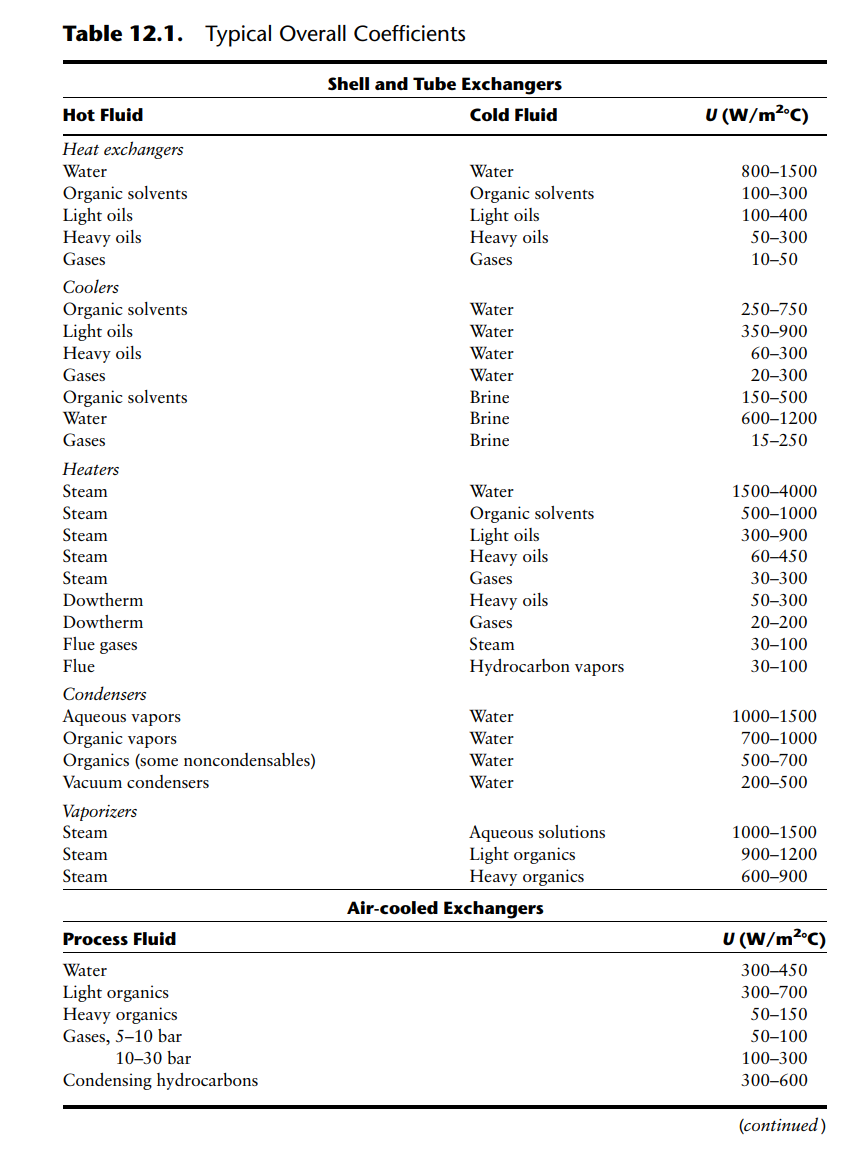

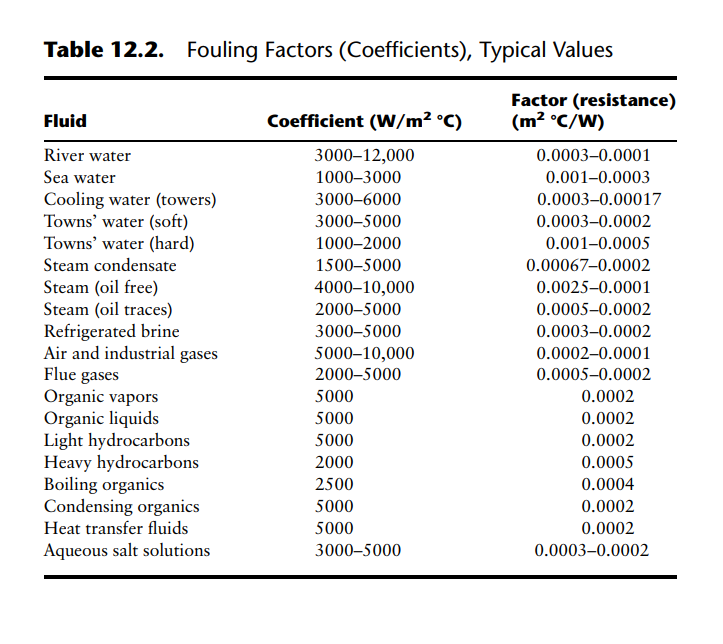

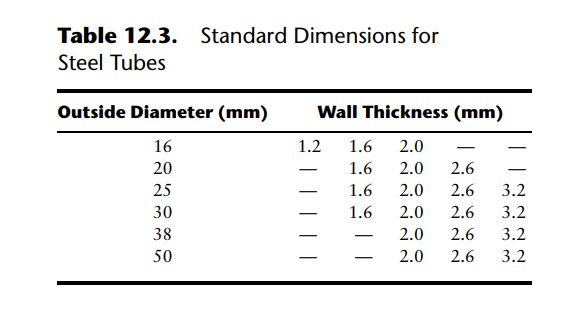

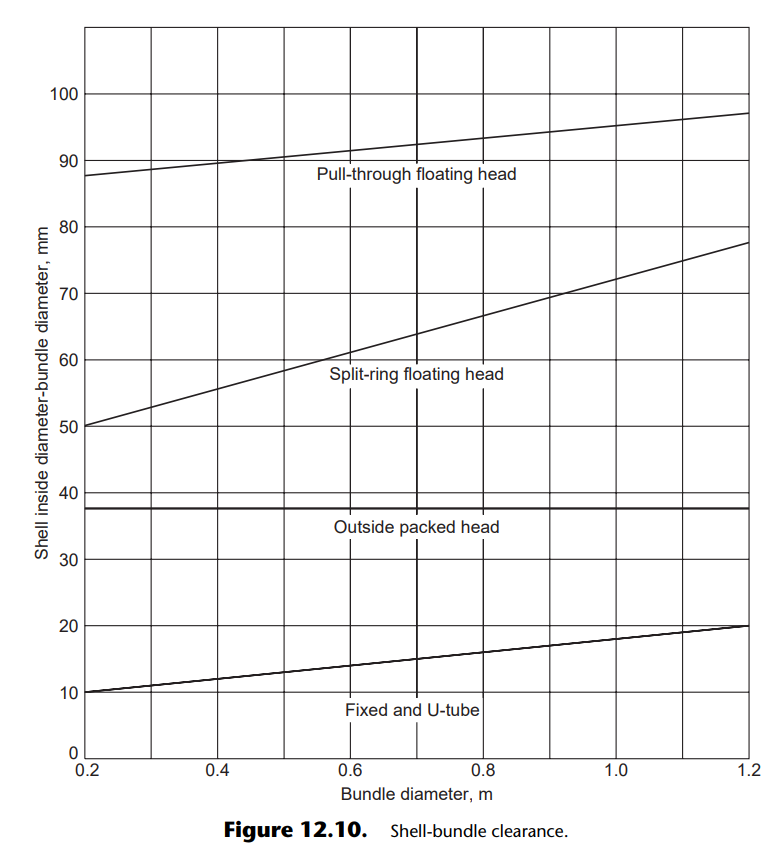

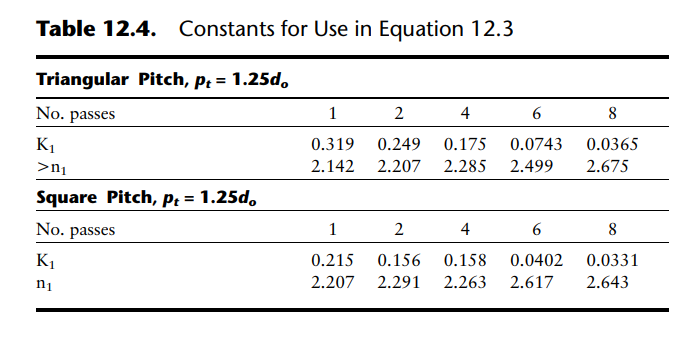

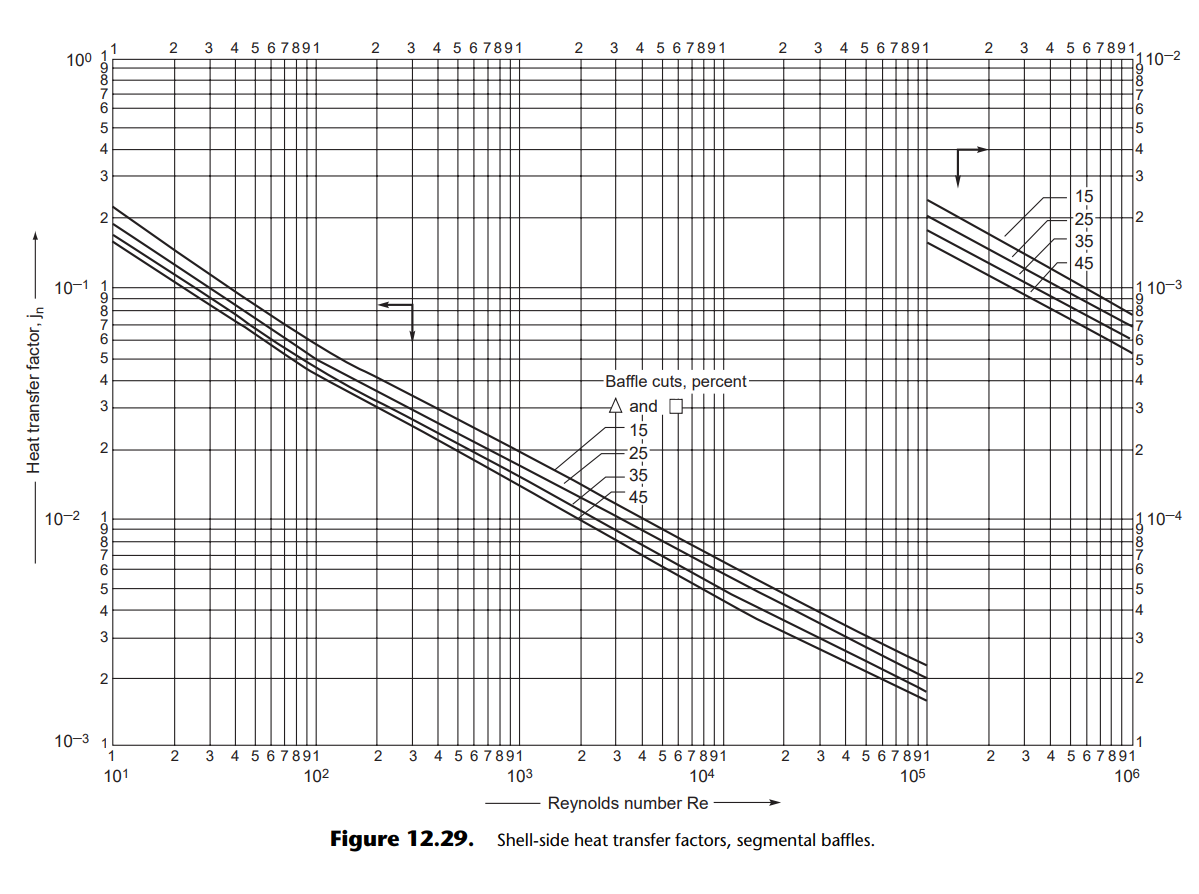

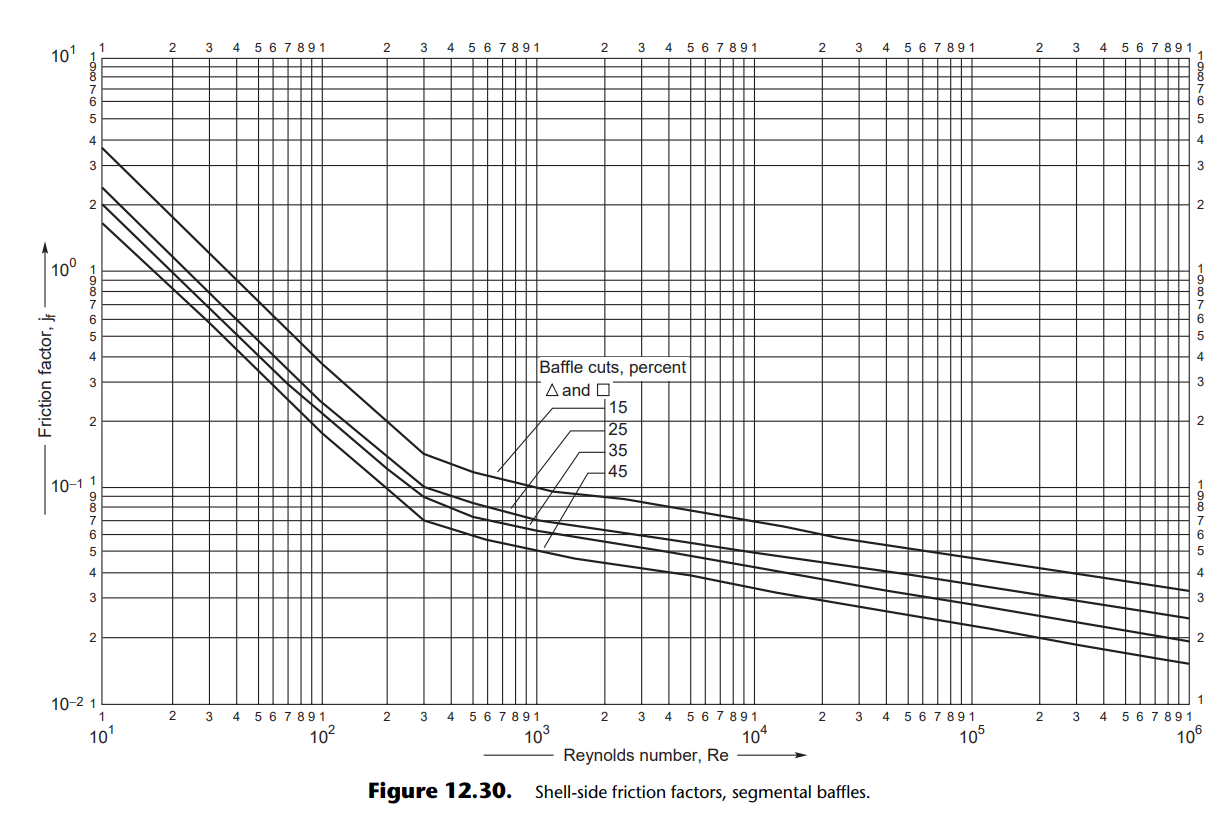

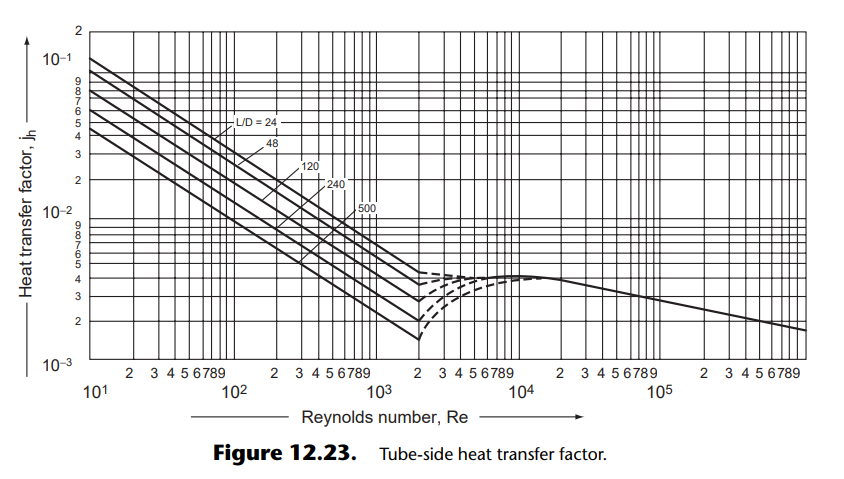

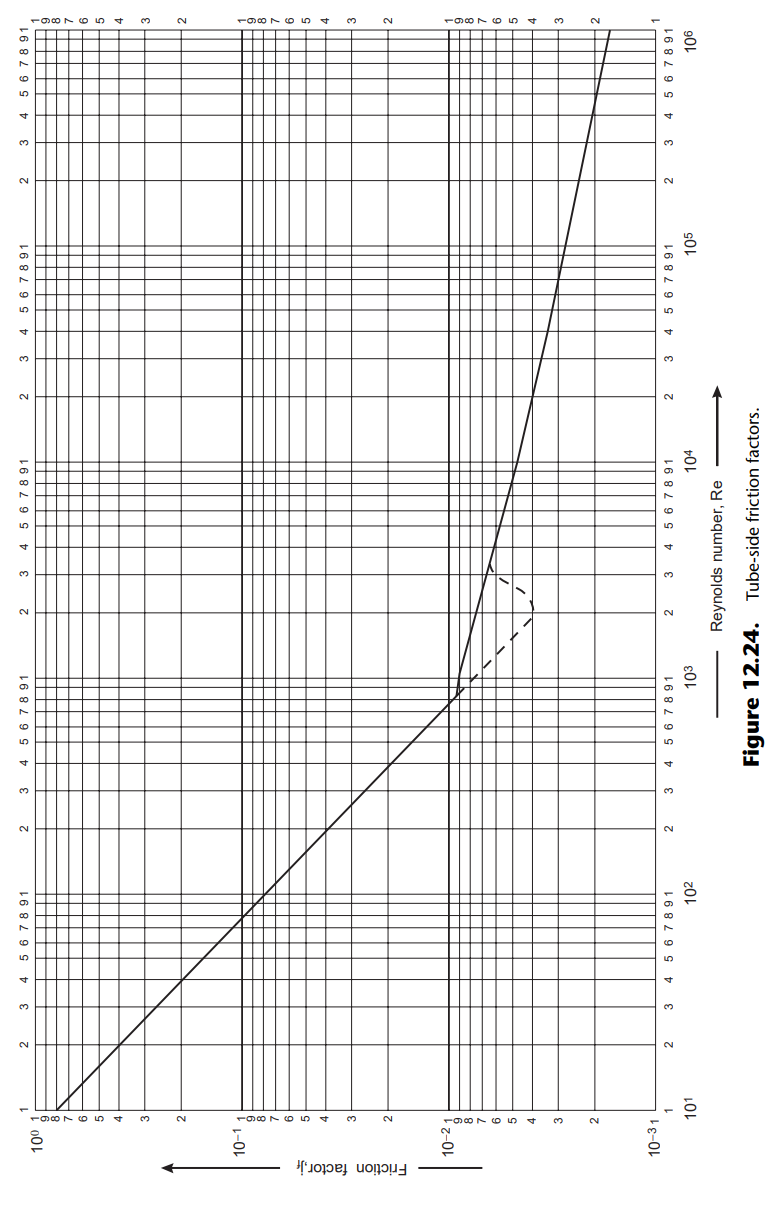